In [81]:
import pandas as pd
import numpy as np
import random

In [82]:
import math, random

def score_to_probability(score, scale=10.0, jitter=0.05):
    """
    Convert risk score into probability with stochasticity and better scaling.

    - score: raw additive risk score
    - scale: sets logistic slope/spread (higher = wider spread)
    - jitter: magnitude of random noise (~0.05 = ±5%)
    """
    # logistic baseline
    prob = 1.0 / (1.0 + math.exp(-(score - scale/2) / (0.25*scale)))

    # random jitter ~ Normal(0, jitter)
    noise = random.gauss(0, jitter)
    prob = prob + noise

    # squash into [0,1]
    prob = max(0.0, min(1.0, prob))
    return prob


In [83]:
def assign_risk(age, bmi, smoking, alcohol, activity, sleep, fruitveg,
                fam_hd, fam_db, bp_sys, bp_dia, glucose, cholesterol, existing):
    """
    Heuristic, guideline-informed risk scoring for multiple domains.
    Not a diagnostic tool. Calibrated to produce intuitive 0–1 probabilities.
    """

    # --- normalize some inputs ---
    smoking = (smoking or "").lower()
    alcohol  = (alcohol  or "").lower()
    activity = (activity or "").lower()
    existing = (existing or "").lower()

    risks = {}

    # -----------------------------
    # Cardiovascular (ASCVD-like)
    # -----------------------------
    # BP per 2017 ACC/AHA categories
    if bp_sys <= 120 and bp_dia <= 80:
        bp_cat = "normal";  bp_score = 0
    elif 120 < bp_sys < 130 and bp_dia < 80:
        bp_cat = "elevated"; bp_score = 1
    elif (130 <= bp_sys < 140) or (80 <= bp_dia < 90):
        bp_cat = "stage1";  bp_score = 2
    else:
        bp_cat = "stage2";  bp_score = 3

    # Smoking intensity mapping (approx. pack-year proxy)
    # tuned to GOLD/epidemiology gradations
    smoking_map = {
        "never": 0,
        "passive": 0.5,
        "former": 1.0,
        "occasional": 1.2,
        "current_light": 2.0,
        "current": 2.5,
        "current_heavy": 3.2,
    }
    smk = smoking_map.get(smoking, 0)

    # Physical activity (WHO 150–300 min/wk target approximated)
    act_map = {"high": 0, "moderate": 0.7, "low": 1.4}
    act = act_map.get(activity, 0.7)

    # Cholesterol (uses TOTAL, stepwise; would be better with LDL/HDL)
    if cholesterol is None:
        chol_step = 0
    elif cholesterol < 200:
        chol_step = 0
    elif 200 <= cholesterol < 240:
        chol_step = 1
    elif 240 <= cholesterol < 280:
        chol_step = 2
    else:
        chol_step = 3

    # Glycemia (ADA)
    if glucose is None:
        glu_step = 0
    elif glucose < 100:
        glu_step = 0
    elif 100 <= glucose < 126:
        glu_step = 1     # prediabetes
    else:
        glu_step = 2     # diabetes-range

    # Family history (premature ASCVD proxy via any family heart disease flag)
    fh = 1 if fam_hd else 0

    # Age banding (nonlinear)
    age_step = 0
    if age >= 40: age_step += 1
    if age >= 55: age_step += 1
    if age >= 65: age_step += 1
    if age >= 75: age_step += 1  # extra weight for very old

    # BMI effect (U-shaped; strong for obesity)
    bmi_term = 0
    if bmi is not None:
        if bmi < 18.5: bmi_term += 0.5
        if 25 <= bmi < 30: bmi_term += 0.5
        if 30 <= bmi < 35: bmi_term += 1.0
        if 35 <= bmi:      bmi_term += 1.8

    # Interactions reflecting guideline emphasis
    interact = 0
    # Hypertension hits harder with diabetes-range glucose
    if glu_step == 2 and bp_cat in ("stage1", "stage2"):
        interact += 1.2
    # Older smokers penalty
    if age >= 60 and smk >= 2.0:
        interact += 1.2
    # High cholesterol with age (atherogenic burden)
    if chol_step >= 2 and age >= 55:
        interact += 0.8
    # Low activity + obesity synergy
    if act >= 1.4 and bmi is not None and bmi >= 30:
        interact += 0.6

    cardio_score = (
        1.2*bp_score     # BP per category (higher weight)
        + 1.0*chol_step
        + 1.1*smk
        + 0.9*glu_step
        + 0.6*fh
        + 0.7*act
        + 0.6*bmi_term
        + 0.9*age_step
        + interact
    )
    # scale ~12–14 feels right for logistic
    risks["Cardiovascular"] = score_to_probability(cardio_score, 22)

    # -----------------------------
    # Metabolic / Endocrine
    # -----------------------------
    # This cluster approximates metabolic syndrome/NAFLD/insulin resistance burden.
    met = 0

    # BMI: non-linear rise above 25, sharper >30 and >35
    if bmi is not None:
        if bmi > 25:
            met += min(((bmi - 25) / 5) ** 1.1, 3.0)  # smooth, capped
        if bmi >= 30: met += 0.8
        if bmi >= 35: met += 0.8

    # Glucose continuum (ADA): 100–125 (IFG), >=126 diabetes-range
    if glucose is not None:
        if glucose >= 100:  met += (glucose - 100) / 30.0  # ~1 point by 130
        if glucose >= 126:  met += 1.0

    # Dyslipidemia proxy from total cholesterol
    if cholesterol is not None and cholesterol > 200:
        met += (cholesterol - 200) / 60.0  # +1 by 260

    # Family history of diabetes
    if fam_db: met += 1.0

    # Low activity is a key driver
    met += 0.8 if activity == "low" else (0.3 if activity == "moderate" else 0)

    # Hypertensive ranges add to metabolic risk burden
    met += { "normal":0, "elevated":0.3, "stage1":0.6, "stage2":1.0 }[bp_cat]

    # Nutritional quality proxy and sleep (U-shaped)
    if fruitveg is not None:
        if fruitveg < 2: met += 1.0
        elif fruitveg < 5: met += 0.4
    if sleep is not None:
        if sleep < 6: met += 0.5
        elif sleep > 9: met += 0.3

    risks["Metabolic_Endocrine"] = score_to_probability(met, 15.0)

    # -----------------------------
    # Respiratory (COPD/asthma risk)
    # -----------------------------
    resp = 0

    # Smoking dominates
    resp += { 0:0, 0.5:0.4, 1.0:0.8, 1.2:1.1, 2.0:1.7, 2.5:2.2, 3.2:3.0 }.get(smk, 0)

    # BMI effect (both obesity and underweight can worsen mechanics/OSA/COPD outcomes)
    if bmi is not None:
        if bmi >= 35: resp += 0.8
        elif bmi >= 30: resp += 0.5
        elif bmi < 18.5: resp += 0.4

    # Sleep deprivation worsens respiratory symptoms/exacerbations risk (proxy)
    if sleep is not None and sleep < 7:
        resp += (7 - sleep) * 0.25

    # Pre-existing
    # asthma -> moderate bump, copd -> strong, hypertension/diabetes -> small
    resp += {"asthma":1.3, "copd":2.5, "hypertension":0.2, "diabetes":0.2}.get(existing, 0)

    # Age (airflow decline) and activity (deconditioning)
    if age >= 50: resp += 0.5
    if activity == "low": resp += 0.4

    risks["Respiratory"] = score_to_probability(resp, 8.5)

    # -----------------------------
    # Liver (ALD + NAFLD proxies)
    # -----------------------------
    liv = 0

    # Alcohol gradient (risk for alcoholic liver disease)
    if alcohol in ("heavy",):
        liv += 3.0
    elif alcohol in ("regular",):
        liv += 2.0
    elif alcohol in ("occasional",):
        liv += 0.6

    # Metabolic syndrome features -> NAFLD risk
    if bmi is not None:
        if 30 <= bmi < 35: liv += 1.0
        if bmi >= 35:      liv += 2.0
    if glucose is not None and glucose >= 100: liv += 0.8
    if bp_cat in ("stage1","stage2"): liv += 0.6
    if cholesterol is not None and cholesterol >= 240: liv += 0.7

    # Viral hepatitis (if flagged)
    if existing in ["hepatitis", "hepatitis_b", "hepatitis_c"]:
        liv += 3.0

    # Smoking small indirect association
    if smoking in ["current", "current_heavy"]: liv += 0.4

    # Age strengthens fibrosis risk
    if age >= 50: liv += 0.6
    if age >= 65: liv += 0.6

    risks["Liver"] = score_to_probability(liv, 11.0)

    # -----------------------------
    # Nutritional
    # -----------------------------
    nut = 0

    # Fruit/veg target: ≥5/day is protective
    if fruitveg is not None:
        if fruitveg < 2: nut += 2.2
        elif fruitveg < 5: nut += 0.9

    # Activity supports energy balance & metabolic health
    nut += {"low":1.4, "moderate":0.6, "high":0}.get(activity, 0.6)

    # BMI extremes (underweight/obesity)
    if bmi is not None:
        if bmi < 18.5:  nut += 1.6
        elif 25 <= bmi < 30: nut += 0.7
        elif 30 <= bmi < 35: nut += 1.3
        elif bmi >= 35: nut += 2.0

    # Sleep U-shape (short/long)
    if sleep is not None:
        if sleep < 6:  nut += 0.7
        elif sleep > 9: nut += 0.5

    # Existing conditions raise nutritional complexity
    if existing in ["diabetes", "hypertension"]: nut += 0.7

    risks["Nutritional"] = score_to_probability(nut, 7.0)

    return risks


In [84]:
# Number of synthetic users
n = 20000

# Helper function: BMI calculation
def calculate_bmi(height_cm, weight_kg):
    height_m = height_cm / 100
    return round(weight_kg / (height_m ** 2), 1)

# Helper: convert score to 0–1 probability
def score_to_probability(score, max_score):
    prob = min(max(score / max_score, 0), 1)  # Normalize
    # Add slight randomness so not all same values
    # return round(min(max(prob, 0), 1), 2)
    return round(min(max(prob + random.uniform(-0.05, 0.05), 0), 1), 2)

# Categories for random selection
gender_choices = ["male", "female"]
alcohol_choices = ["none", "occasional", "regular", "heavy"]
activity_choices = ["low", "moderate", "high"]
existing_conditions_choices = [
    None,
    "asthma",
    "copd",
    "hypertension",
    "diabetes",
    "chronic_kidney_disease",
    "fatty_liver",
    "hepatitis",
    "coronary_artery_disease",
    "stroke",
    "obesity",
    "sleep_apnea",
    "depression",
    "anxiety"
]
smoking_choices = [
    "never",
    "former",
    "occasional",
    "passive",
    "current_light",
    "current_heavy"
]

# Generate dataset
records = []
for _ in range(n):
    age = random.randint(18, 80)
    gender = random.choice(gender_choices)
    height = random.randint(150, 190)
    weight = random.randint(45, 120)
    bmi = calculate_bmi(height, weight)
    smoking = random.choice(smoking_choices)
    alcohol = random.choice(alcohol_choices)
    activity = random.choice(activity_choices)
    sleep = random.randint(4, 9)
    fruitveg = random.randint(0, 5)
    fam_hd = bool(random.getrandbits(1))
    fam_db = bool(random.getrandbits(1))
    existing = random.choice(existing_conditions_choices)
    bp_sys = random.randint(100, 180)
    bp_dia = random.randint(60, 110)
    glucose = random.randint(70, 200)
    cholesterol = random.randint(150, 300)

    # Assign risk probabilities
    risks = assign_risk(age, bmi, smoking, alcohol, activity, sleep, fruitveg, fam_hd, fam_db, bp_sys, bp_dia, glucose, cholesterol, existing)

    record = {
        "Age": age,
        "Gender": gender,
        "Height_cm": height,
        "Weight_kg": weight,
        "BMI": bmi,
        "SmokingStatus": smoking,
        "AlcoholUse": alcohol,
        "ActivityLevel": activity,
        "SleepHours": sleep,
        "FruitVegIntake": fruitveg,
        "FamilyHistory_HeartDisease": fam_hd,
        "FamilyHistory_Diabetes": fam_db,
        "ExistingConditions": existing,
        "BP_Systolic": bp_sys,
        "BP_Diastolic": bp_dia,
        "FastingGlucose": glucose,
        "Cholesterol": cholesterol,
        "Risk_Cardiovascular": risks["Cardiovascular"],
        "Risk_Metabolic_Endocrine": risks["Metabolic_Endocrine"],
        "Risk_Respiratory": risks["Respiratory"],
        "Risk_Liver": risks["Liver"],
        "Risk_Nutritional": risks["Nutritional"]
    }
    records.append(record)

# Create DataFrame
df = pd.DataFrame(records)

# Save to CSV
df.to_csv("synthetic_health_data_probabilities.csv", index=False)
print("Dataset generated: synthetic_health_data_probabilities.csv")


Dataset generated: synthetic_health_data_probabilities.csv


In [85]:
# # Risk scoring
# def assign_risk(age, bmi, smoking, alcohol, activity, sleep, fruitveg, fam_hd, fam_db, bp_sys, bp_dia, glucose, cholesterol, existing):
#     risks = {}

#     # Cardiovascular (complex version)
#     cardio_score = 0
#     if age > 50: cardio_score += 2
#     if bp_sys > 140 or bp_dia > 90: cardio_score += 2
#     if cholesterol > 240: cardio_score += 3
#     if smoking == "current": cardio_score += 2
#     if fam_hd: cardio_score += 1
#     if activity == "low": cardio_score += 1
#     # Interaction: older smokers suffer extra
#     if age > 60 and smoking == "current":
#         cardio_score += 2
#     # Threshold effect: very high glucose spikes cardio too
#     if glucose > 160:
#         cardio_score += 1
#     risks["Cardiovascular"] = score_to_probability(cardio_score, 12)

#     # Metabolic / Endocrine
#     metabolic_score = 0
#     metabolic_score += min(bmi / 10, 3)              # BMI ka gradual effect
#     metabolic_score += (glucose - 100) / 50 if glucose > 100 else 0  # glucose rising effect
#     metabolic_score += 1 if fam_db else 0
#     metabolic_score += 0.5 if activity == "low" else 0
#     metabolic_score += (cholesterol - 200) / 100 if cholesterol > 200 else 0
#     risks["Metabolic_Endocrine"] = score_to_probability(metabolic_score, 8)


#     # Respiratory Risk Scoring (continuous version)
#     resp_score = 0

#     # --- Smoking impact (continuous: pack-years approx) ---
#     smoking_map = {
#         "never": 0,
#         "passive": 1,
#         "former": 5,
#         "occasional": 3,
#         "current_light": 10,
#         "current_heavy": 20
#     }
#     # normalize into 0–5 scale
#     resp_score += smoking_map.get(smoking, 0) / 4.0
#     # --- BMI effect (gradual nonlinear) ---
#     if bmi > 25:
#         resp_score += min(((bmi - 25) / 5) ** 1.2, 3)  # smoother, capped at 3

#     # --- Sleep effect (gradual penalty) --- [0 - 4.2]
#     if sleep < 7:
#         resp_score += (7 - sleep) * 0.6   # less harsh, continuous

#     # --- Pre-existing conditions (severity continuous instead of hard jump) ---
#     condition_map = {
#         "asthma": 2.5,  # medium impact
#         "copd": 4.0,    # stronger
#         "hypertension": 1.0,  # mild respiratory impact
#         "diabetes": 0.5       # very small indirect effect
#     }
#     resp_score += condition_map.get(existing, 0)

#     # --- Normalize into probability ---
#     risks["Respiratory"] = score_to_probability(resp_score, 16.2)




#     # Liver
#     liver_score = 0

#     # Alcohol use - finer granularity
#     if alcohol == "heavy":
#         liver_score += 4
#     elif alcohol == "regular":
#         liver_score += 3
#     elif alcohol == "occasional":
#         liver_score += 1

#     # BMI / Obesity
#     if bmi >= 35:
#         liver_score += 2
#     elif bmi >= 30:
#         liver_score += 1

#     # Blood sugar
#     if glucose >= 126:
#         liver_score += 2
#     elif glucose >= 110:
#         liver_score += 1

#     # Cholesterol
#     if cholesterol > 280:
#         liver_score += 2
#     elif cholesterol > 240:
#         liver_score += 1

#     # Viral hepatitis history
#     if existing in ["hepatitis"]:
#         liver_score += 3

#     # Smoking (indirect contribution)
#     if smoking in ["current_heavy"]:
#         liver_score += 1

#     risks["Liver"] = score_to_probability(liver_score, 12)


#     # Nutritional
#     nutri_score = 0

#     # fruit/veg intake
#     if fruitveg < 2:
#         nutri_score += 3
#     elif fruitveg < 5:
#         nutri_score += 1

#     # activity
#     if activity == "low":
#         nutri_score += 2
#     elif activity == "moderate":
#         nutri_score += 1

#     # BMI extremes
#     if bmi < 18.5:  # underweight
#         nutri_score += 2
#     elif bmi >= 30:  # obesity
#         nutri_score += 2
#     elif 25 <= bmi < 30:  # overweight
#         nutri_score += 1

#     # sleep
#     if sleep < 6:
#         nutri_score += 1
#     elif sleep > 9:
#         nutri_score += 1

#     # existing conditions
#     if existing in ["diabetes", "hypertension"]:
#         nutri_score += 1
#     risks["Nutritional"] = score_to_probability(nutri_score, 10)


#     return risks

In [86]:
import xgboost as xgb

# check GPU availability
def make_xgb_model():
    try:
        # Try GPU first
        model = xgb.XGBRegressor(
            n_estimators=300,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            tree_method="hist",   # hist works on both CPU & GPU
            device="cuda"         # if GPU is available
        )
        model.fit([[0]], [0])  # tiny test fit
        return model
    except Exception as e:
        print("⚠️ GPU not available → Falling back to CPU")
        return xgb.XGBRegressor(
            n_estimators=300,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            tree_method="hist",   # safe CPU mode
            device="cpu"
        )


In [87]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(y_test, y_pred, target_name):
    plt.figure(figsize=(6,6))
    # Scatter points
    plt.scatter(y_test, y_pred, alpha=0.5, label="Predicted vs Actual")
    # Perfect prediction line
    lims = [
        np.min([y_test.min(), y_pred.min()]),
        np.max([y_test.max(), y_pred.max()])
    ]
    plt.plot(lims, lims, 'r--', label="Perfect prediction")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{target_name} — Actual vs Predicted")
    plt.legend()
    plt.grid(True)
    plt.show()



=== Training XGBoost for Risk_Cardiovascular ===


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:22:40] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:22:40] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:22:41] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:22:41] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost → MSE: 0.0010, R²: 0.9532


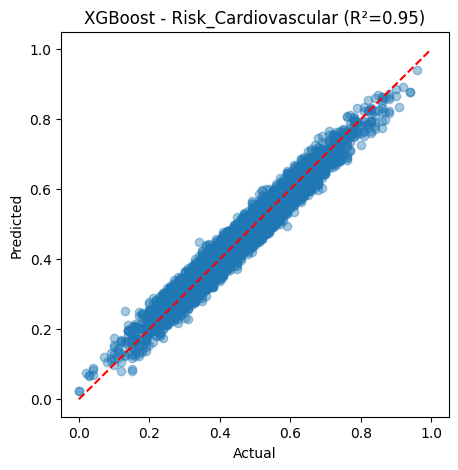


=== Training XGBoost for Risk_Metabolic_Endocrine ===


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:22:43] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:22:43] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:22:44] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:22:44] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost → MSE: 0.0010, R²: 0.9688


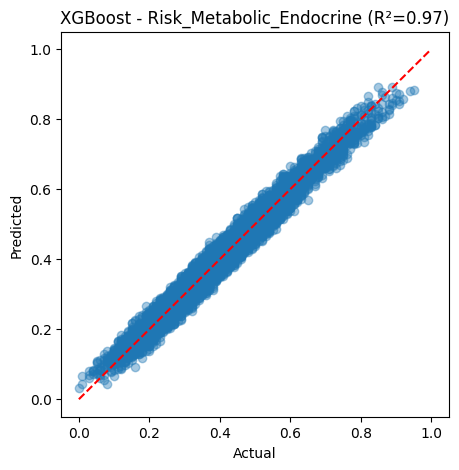


=== Training XGBoost for Risk_Respiratory ===


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:22:45] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:22:45] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:22:46] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:22:46] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost → MSE: 0.0009, R²: 0.9641


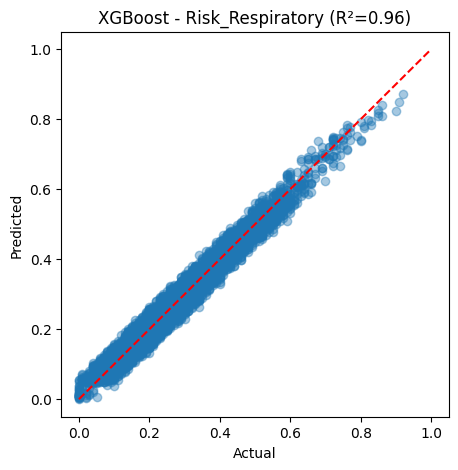


=== Training XGBoost for Risk_Liver ===


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:22:49] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:22:49] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:22:50] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:22:50] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost → MSE: 0.0009, R²: 0.9663


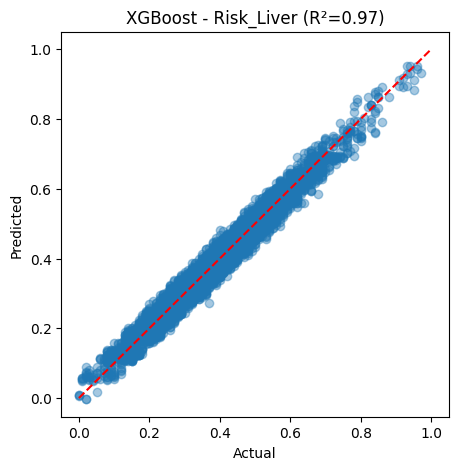


=== Training XGBoost for Risk_Nutritional ===


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:22:51] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:22:51] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:22:52] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:22:52] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost → MSE: 0.0009, R²: 0.9745


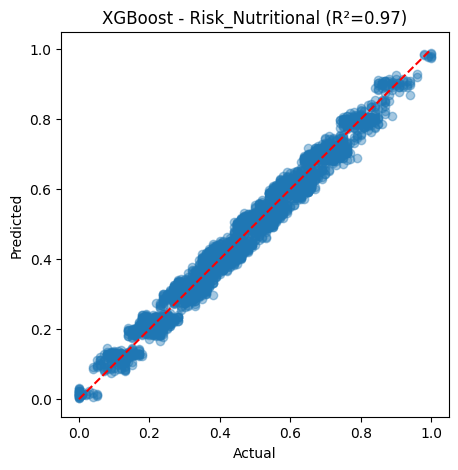

Encoders saved successfully.
Scaler saved successfully.

=== Final Summary (XGBoost only) ===
Risk_Cardiovascular       → MSE: 0.0010, R²: 0.9532
Risk_Metabolic_Endocrine  → MSE: 0.0010, R²: 0.9688
Risk_Respiratory          → MSE: 0.0009, R²: 0.9641
Risk_Liver                → MSE: 0.0009, R²: 0.9663
Risk_Nutritional          → MSE: 0.0009, R²: 0.9745


In [88]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import os
import joblib

# ------------------------
# Load dataset
# ------------------------
df = pd.read_csv("synthetic_health_data_probabilities.csv")

# Encode categorical features
categorical_cols = ["Gender", "SmokingStatus", "AlcoholUse", "ActivityLevel", "ExistingConditions"]
df[categorical_cols] = df[categorical_cols].astype(str)

encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

# Features (X) and targets (y)
X = df.drop(columns=[
    "Risk_Cardiovascular", "Risk_Metabolic_Endocrine",
    "Risk_Respiratory", "Risk_Liver", "Risk_Nutritional"
])
y = df[[
    "Risk_Cardiovascular", "Risk_Metabolic_Endocrine",
    "Risk_Respiratory", "Risk_Liver", "Risk_Nutritional"
]]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ------------------------
# Train XGBoost for each target
# ------------------------
results = {}
trained_models = {}
os.makedirs("plots_xgboost", exist_ok=True)

for target in y.columns:
    print(f"\n=== Training XGBoost for {target} ===")
    model = make_xgb_model()
    model.fit(X_train, y_train[target])

    model.fit(X_train, y_train[target])
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test[target], y_pred)
    r2 = r2_score(y_test[target], y_pred)
    results[target] = {"MSE": mse, "R2": r2}
    trained_models[target] = model

    print(f"XGBoost → MSE: {mse:.4f}, R²: {r2:.4f}")

    # Save scatter plot
    plt.figure(figsize=(5,5))
    plt.scatter(y_test[target], y_pred, alpha=0.4)
    plt.plot([0,1],[0,1],'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"XGBoost - {target} (R²={r2:.2f})")
    plt.savefig(f"plots_xgboost/{target}_xgboost.png")
    plt.show()
    plt.close()

    # ------------------------
    # Save the trained model
    # ------------------------
    os.makedirs("trained_models", exist_ok=True)
    joblib.dump(model, f"trained_models/xgb_{target}.joblib")



# ------------------------
# Save encoders and scaler
# ------------------------
os.makedirs("trained_models", exist_ok=True)

# Save LabelEncoders
joblib.dump(encoders, "trained_models/encoders.joblib")
print("Encoders saved successfully.")

# Save StandardScaler
joblib.dump(scaler, "trained_models/scaler.joblib")
print("Scaler saved successfully.")

# Save Feature names
joblib.dump(X.columns.tolist(), "trained_models/training_columns.joblib")


# ------------------------
# Summary
# ------------------------
print("\n=== Final Summary (XGBoost only) ===")
for target, metrics in results.items():
    print(f"{target:25} → MSE: {metrics['MSE']:.4f}, R²: {metrics['R2']:.4f}")


In [89]:
!ls -al trained_models/

total 7128
drwxr-xr-x 2 root root    4096 Aug 16 14:07 .
drwxr-xr-x 1 root root    4096 Aug 16 14:07 ..
-rw-r--r-- 1 root root    1719 Aug 16 14:22 encoders.joblib
-rw-r--r-- 1 root root    1519 Aug 16 14:22 scaler.joblib
-rw-r--r-- 1 root root     271 Aug 16 14:22 training_columns.joblib
-rw-r--r-- 1 root root 1459444 Aug 16 14:22 xgb_Risk_Cardiovascular.joblib
-rw-r--r-- 1 root root 1452169 Aug 16 14:22 xgb_Risk_Liver.joblib
-rw-r--r-- 1 root root 1450800 Aug 16 14:22 xgb_Risk_Metabolic_Endocrine.joblib
-rw-r--r-- 1 root root 1453326 Aug 16 14:22 xgb_Risk_Nutritional.joblib
-rw-r--r-- 1 root root 1451084 Aug 16 14:22 xgb_Risk_Respiratory.joblib


In [116]:
import pandas as pd
import numpy as np
import joblib
import os

# ------------------------
# Load trained models
# ------------------------
model_files = {
    "cardiovascular": "trained_models/xgb_Risk_Cardiovascular.joblib",
    "metabolic": "trained_models/xgb_Risk_Metabolic_Endocrine.joblib",
    "respiratory": "trained_models/xgb_Risk_Respiratory.joblib",
    "liver": "trained_models/xgb_Risk_Liver.joblib",
    "nutritional": "trained_models/xgb_Risk_Nutritional.joblib",
}

trained_models = {k: joblib.load(v) for k, v in model_files.items()}

# ------------------------
# Load encoders and scaler
# ------------------------
encoders = joblib.load("trained_models/encoders.joblib")
scaler = joblib.load("trained_models/scaler.joblib")

categorical_cols = ["Gender", "SmokingStatus", "AlcoholUse", "ActivityLevel", "ExistingConditions"]

# ------------------------
# Prediction function
# ------------------------
def predict_risk(input_data: dict) -> dict:

    # bmi = calculate_bmi(input_data.get("Height_cm", input_data.get("Weight_kg")))
    df = pd.DataFrame([input_data])

    # Ensure all categorical columns exist
    for col in categorical_cols:
        if col not in df.columns:
            df[col] = "none"

    # Encode categorical features
    for col in categorical_cols:
        if col in encoders:
            le = encoders[col]
            df[col] = df[col].map(lambda x: x if x in le.classes_ else le.classes_[0])
            df[col] = le.transform(df[col])

    # Ensure all numeric columns from training exist
    numeric_cols = ["BP_Systolic", "BP_Diastolic", "Cholesterol", "FastingGlucose", "FamilyHistory_Diabetes"]
    for col in numeric_cols:
        if col not in df.columns:
            df[col] = 0  # default value

    # Drop any risk columns if present
    X_input = df.drop(columns=[c for c in df.columns if c.startswith("Risk_")], errors='ignore')

    # Reorder columns exactly like training
    training_cols = joblib.load("trained_models/training_columns.joblib")  # save this during training
    X_input = X_input[training_cols]

    # Standardize features
    X_scaled = scaler.transform(X_input)

    # Predict each target and convert to percentage
    predictions = {}
    for key, model in trained_models.items():
        pred = model.predict(X_scaled)[0]  # single row
        # predictions[key] = round(float(np.clip(pred, 0, 1)) * 100, 2)
        predictions[key] = round(float(np.clip(pred, 0, 1)) * 100, 2)

    return predictions


# ------------------------
# Example test cases
# ------------------------
test_cases = [
    # {
    #     "Age": 60,
    #     "Gender": "male",
    #     "Height_cm": 175,
    #     "Weight_kg": 75,
    #     "BMI": 24.5,
    #     "SmokingStatus": "never",
    #     "AlcoholUse": "none",
    #     "ActivityLevel": "moderate",
    #     "SleepHours": 7,
    #     "FruitVegIntake": 3,
    #     "ExistingConditions": "none",
    #     "FamilyHistory_HeartDisease": False,
    # },
    # {
    #     "Age": 45,
    #     "Gender": "female",
    #     "Height_cm": 160,
    #     "Weight_kg": 82,
    #     "BMI": 32.0,
    #     "SmokingStatus": "current",
    #     "AlcoholUse": "regular",
    #     "ActivityLevel": "low",
    #     "SleepHours": 5,
    #     "FruitVegIntake": 1,
    #     "ExistingConditions": "hypertension",
    #     "FamilyHistory_HeartDisease": True,
    # },
    {
        "Age": 22,
        "Gender": "male",
        "Height_cm": 175,
        "Weight_kg": 72,
        "BMI": 23.5,
        "SmokingStatus": "never",
        "AlcoholUse": "none",
        "ActivityLevel": "moderate",
        "SleepHours": 7,
        "FruitVegIntake": 2,
        "FamilyHistory_HeartDisease": False,
        "FamilyHistory_Diabetic": False,
        "ExistingConditions": None,
        "BP_Systolic": 180,
        "BP_Diastolic": 80,
        "FastingGlucose": 95,
        "Cholesterol": 195
    }
]

# ------------------------
# Run test cases
# ------------------------
for i, case in enumerate(test_cases, 1):
    print(f"\nTest Case {i}:")
    print("Input:", case)
    result = predict_risk(case)

    # Transform the input to match assign_risk arguments
    age = case["Age"]
    bmi = case["BMI"]  # Already provided
    smoking = case["SmokingStatus"]
    alcohol = case["AlcoholUse"]
    activity = case["ActivityLevel"]
    sleep = case["SleepHours"]
    fruitveg = case["FruitVegIntake"]
    fam_hd = case["FamilyHistory_HeartDisease"]
    fam_db = case["FamilyHistory_Diabetic"]
    existing = case["ExistingConditions"]
    bp_sys = case["BP_Systolic"]
    bp_dia = case["BP_Diastolic"]
    glucose = case["FastingGlucose"]
    cholesterol = case["Cholesterol"]

    # Call the risk assignment function
    risks = assign_risk(age, bmi, smoking, alcohol, activity, sleep, fruitveg, fam_hd, fam_db, bp_sys, bp_dia, glucose, cholesterol, existing)
    print("Function result: ", risks)
    print("Predicted Risks (%):", result)



Test Case 1:
Input: {'Age': 22, 'Gender': 'male', 'Height_cm': 175, 'Weight_kg': 72, 'BMI': 23.5, 'SmokingStatus': 'never', 'AlcoholUse': 'none', 'ActivityLevel': 'moderate', 'SleepHours': 7, 'FruitVegIntake': 2, 'FamilyHistory_HeartDisease': False, 'FamilyHistory_Diabetic': False, 'ExistingConditions': None, 'BP_Systolic': 180, 'BP_Diastolic': 80, 'FastingGlucose': 95, 'Cholesterol': 195}
Function result:  {'Cardiovascular': 0.09777259985079931, 'Metabolic_Endocrine': 0.20181322226037884, 'Respiratory': 0.03444519566621117, 'Liver': 0.03444519566621117, 'Nutritional': 0.11920292202211755}
Predicted Risks (%): {'cardiovascular': 13.32, 'metabolic': 8.59, 'respiratory': 0.98, 'liver': 5.87, 'nutritional': 21.35}


In [110]:
import shutil

shutil.make_archive("trained_models", 'zip', "trained_models")
print("trained_models.zip created successfully")
shutil.make_archive("plots_xgboost", 'zip', "plots_xgboost")
print("plots_xgboost.zip created successfully")

trained_models.zip created successfully
plots_xgboost.zip created successfully


In [92]:
import math
def score_to_probability(score, scale=10.0):
            # smoother logistic: higher 'scale' spreads scores out
            return 1.0 / (1.0 + math.exp(-(score - scale/2) / (0.15*scale)))


for i in range(11):
  print(i, score_to_probability(i))

0 0.03444519566621117
1 0.06496916912866407
2 0.11920292202211755
3 0.20860852732604496
4 0.33924363123418283
5 0.5
6 0.6607563687658172
7 0.791391472673955
8 0.8807970779778823
9 0.935030830871336
10 0.9655548043337889


In [115]:
!pip list

Package                               Version
------------------------------------- ------------------
absl-py                               1.4.0
accelerate                            1.10.0
aiofiles                              24.1.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.12.15
aiosignal                             1.4.0
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.8
ale-py                                0.11.2
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.10.0
anywidget                             0.9.18
argon2-cffi                           25.1.0
argon2-cffi-bindings                  25.1.0
array_record                          0.7.2
arviz                                 0.22.0
astropy                               7.1.0
astrop